In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score, f1_score, recall_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import MultiTaskLasso
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LassoLars
from math import sqrt
import pickle

In [2]:
df=pd.read_csv('./input/train.csv',encoding='latin-1')

In [3]:
df = df.set_index('id', drop=True)

In [4]:
df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
id,,,,,,,,,,
0,1.12,Premium,H,SI1,61.6,59.0,6.67,6.63,4.10,5363
1,1.14,Very Good,E,SI2,60.0,54.0,6.74,6.97,4.11,5593
2,0.90,Very Good,D,SI2,60.3,63.0,6.12,6.22,3.72,3534
3,0.71,Ideal,E,VS1,61.9,54.0,5.74,5.76,3.56,3212
4,0.34,Very Good,F,SI2,60.0,62.0,4.51,4.55,2.72,447


In [5]:
print(df.info, df.dtypes)

<bound method DataFrame.info of        carat        cut color clarity  depth  table     x     y     z  price
id                                                                          
0       1.12    Premium     H     SI1   61.6   59.0  6.67  6.63  4.10   5363
1       1.14  Very Good     E     SI2   60.0   54.0  6.74  6.97  4.11   5593
2       0.90  Very Good     D     SI2   60.3   63.0  6.12  6.22  3.72   3534
3       0.71      Ideal     E     VS1   61.9   54.0  5.74  5.76  3.56   3212
4       0.34  Very Good     F     SI2   60.0   62.0  4.51  4.55  2.72    447
...      ...        ...   ...     ...    ...    ...   ...   ...   ...    ...
40450   0.90       Good     D     SI1   63.8   58.0  6.13  6.09  3.90   4120
40451   0.35      Ideal     D    VVS1   62.0   54.0  4.56  4.57  2.83   1266
40452   0.90       Good     G     SI2   58.4   55.0  6.34  6.39  3.72   3269
40453   1.21       Good     H     SI1   63.6   56.0  6.63  6.68  4.23   5893
40454   0.41      Ideal     H    VVS1   61.4

In [6]:
df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

In [7]:
df.describe()

,carat,depth,table,x,y,z,price
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,0.798121,61.745132,57.451892,5.731217,5.735248,3.538685,3938.101125
std,0.474880,1.434259,2.225893,1.123364,1.152859,0.710579,3992.645108
min,0.200000,43.000000,43.000000,0.000000,0.000000,0.000000,326.000000
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,948.000000
50%,0.700000,61.800000,57.000000,5.700000,5.710000,3.520000,2401.000000
75%,1.040000,62.500000,59.000000,6.540000,6.540000,4.040000,5333.000000
max,5.010000,79.000000,79.000000,10.740000,58.900000,31.800000,18818.000000


In [8]:
#Checking on price-to-size relation
df['size']=round(df['x']*df['y']*df['z'], 1)
df['prize-to-size']=round(df['price']/df['size'], 1)
df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price,size,prize-to-size
id,,,,,,,,,,,,
0,1.12,Premium,H,SI1,61.6,59.0,6.67,6.63,4.10,5363,181.3,29.6
1,1.14,Very Good,E,SI2,60.0,54.0,6.74,6.97,4.11,5593,193.1,29.0
2,0.90,Very Good,D,SI2,60.3,63.0,6.12,6.22,3.72,3534,141.6,25.0
3,0.71,Ideal,E,VS1,61.9,54.0,5.74,5.76,3.56,3212,117.7,27.3
4,0.34,Very Good,F,SI2,60.0,62.0,4.51,4.55,2.72,447,55.8,8.0


In [9]:
print('CUT\n', df.cut.value_counts(),'\n\nCOLOR\n', df.color.value_counts(), '\n\nCLARITY\n', df.clarity.value_counts())

CUT
 Ideal        16250
Premium      10342
Very Good     9026
Good          3639
Fair          1198
Name: cut, dtype: int64 

COLOR
 G    8565
E    7344
F    7162
H    6147
D    5063
I    4052
J    2122
Name: color, dtype: int64 

CLARITY
 SI1     9806
VS2     9204
SI2     6865
VS1     6099
VVS2    3778
VVS1    2776
IF      1365
I1       562
Name: clarity, dtype: int64


In [10]:
labels_cut= {'Fair': 4,'Good': 3, 'Very Good': 2, 'Premium': 1, 'Ideal': 0}
labels_color= {'J': 6,'I': 5,'H': 4,'G': 3,'F': 2,'E': 1,'D': 0}
labels_clarity= {'I1': 7,'SI2': 6,'SI1': 5,'VS2': 4,'VS1': 3,'VVS2': 2,'VVS1': 1,'IF': 0}

In [11]:
df1 = df.replace({'cut': labels_cut})
df1 = df1.replace({'color': labels_color})
df1 = df1.replace({'clarity': labels_clarity})

In [12]:
df_dumb=pd.get_dummies(df)
df_dumb.head()

,carat,depth,table,x,y,z,price,size,prize-to-size,cut_Fair,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
id,,,,,,,,,,,,,,,,,,,,,
0,1.12,61.6,59.0,6.67,6.63,4.10,5363,181.3,29.6,0,...,0,0,0,0,1,0,0,0,0,0
1,1.14,60.0,54.0,6.74,6.97,4.11,5593,193.1,29.0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.90,60.3,63.0,6.12,6.22,3.72,3534,141.6,25.0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.71,61.9,54.0,5.74,5.76,3.56,3212,117.7,27.3,0,...,0,0,0,0,0,0,1,0,0,0
4,0.34,60.0,62.0,4.51,4.55,2.72,447,55.8,8.0,0,...,0,0,0,0,0,1,0,0,0,0


In [13]:
train_dataset = df1
train_dataset

,carat,cut,color,clarity,depth,table,x,y,z,price,size,prize-to-size
id,,,,,,,,,,,,
0,1.12,1,4,5,61.6,59.0,6.67,6.63,4.10,5363,181.3,29.6
1,1.14,2,1,6,60.0,54.0,6.74,6.97,4.11,5593,193.1,29.0
2,0.90,2,0,6,60.3,63.0,6.12,6.22,3.72,3534,141.6,25.0
3,0.71,0,1,3,61.9,54.0,5.74,5.76,3.56,3212,117.7,27.3
4,0.34,2,2,6,60.0,62.0,4.51,4.55,2.72,447,55.8,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
40450,0.90,3,0,5,63.8,58.0,6.13,6.09,3.90,4120,145.6,28.3
40451,0.35,0,0,1,62.0,54.0,4.56,4.57,2.83,1266,59.0,21.5
40452,0.90,3,3,6,58.4,55.0,6.34,6.39,3.72,3269,150.7,21.7


In [14]:
round(train_dataset.describe(),1)

,carat,cut,color,clarity,depth,table,x,y,z,price,size,prize-to-size
count,40455.0,40455.0,40455.0,40455.0,40455.0,40455.0,40455.0,40455.0,40455.0,40455.0,40455.0,40455.0
mean,0.8,1.1,2.6,3.9,61.7,57.5,5.7,5.7,3.5,3938.1,129.9,inf
std,0.5,1.1,1.7,1.7,1.4,2.2,1.1,1.2,0.7,3992.6,79.0,NaN
min,0.2,0.0,0.0,0.0,43.0,43.0,0.0,0.0,0.0,326.0,0.0,2.3
25%,0.4,0.0,1.0,3.0,61.0,56.0,4.7,4.7,2.9,948.0,65.1,15.1
50%,0.7,1.0,3.0,4.0,61.8,57.0,5.7,5.7,3.5,2401.0,114.9,21.5
75%,1.0,2.0,4.0,5.0,62.5,59.0,6.5,6.5,4.0,5333.0,171.0,30.5
max,5.0,4.0,6.0,7.0,79.0,79.0,10.7,58.9,31.8,18818.0,3840.6,inf


In [15]:
train_dataset.dtypes

carat            float64
cut                int64
color              int64
clarity            int64
depth            float64
table            float64
x                float64
y                float64
z                float64
price              int64
size             float64
prize-to-size    float64
dtype: object

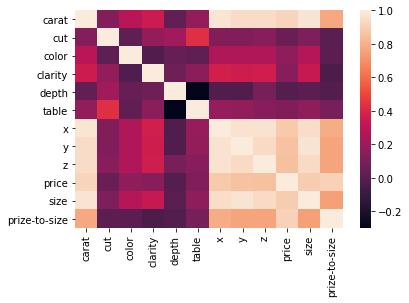

In [16]:
display(sns.heatmap(train_dataset.corr()))

In [24]:
columnas = [a for a in train_dataset.columns if a not in ['price','size','prize-to-size','x','y','z']]
X = train_dataset[columnas]
y = train_dataset['price']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In [26]:
linear=LinearRegression()
print(linear.fit(X_train,y_train))
print(linear.score(X_test,y_test))
y_pred_test = linear.predict(X_test)
y_pred_train = linear.predict(X_train)

LinearRegression()
0.9020705864313942


In [27]:
print('TEST')
print ("R2", round(r2_score(y_test,y_pred_test),5))
print("mean_squared_error",round(mean_squared_error(y_test,y_pred_test),5))
print("mean_absolute_error", round(mean_absolute_error(y_test,y_pred_test),5))

TEST
R2 0.90207
mean_squared_error 1571981.50589
mean_absolute_error 866.34472


In [28]:
print('TRAIN')
print ("R2", round(r2_score(y_train,y_pred_train),5))
print("mean_squared_error",round(mean_squared_error(y_train,y_pred_train),5))
print("mean_absolute_error", round(mean_absolute_error(y_train,y_pred_train),5))

TRAIN
R2 0.90432
mean_squared_error 1522585.16771
mean_absolute_error 854.35673


In [29]:
num_folds = 4
models = {
'RandomForest': RandomForestRegressor(n_estimators=500)
}

LassoLars
final_models=[]


for name, model in models.items():
    kfold = KFold(n_splits=num_folds, random_state=None)
    cv_results_test_R2 = cross_val_score(model, X_test, y_test, cv=kfold,    scoring='r2', verbose=1)
    cv_results_test_MSE = cross_val_score(model, X_test, y_test, cv=kfold,    scoring='neg_root_mean_squared_error', verbose=1)
    print(f"-------{name}-------")
    print('Test:')
    print("R2:",cv_results_test_R2.mean())
    print("MSE:",-cv_results_test_MSE.mean())
    cv_results_train_R2 = cross_val_score(model, X_train, y_train, cv=kfold,    scoring='r2', verbose=1)
    cv_results_train_MSE = cross_val_score(model, X_train, y_train, cv=kfold,    scoring='neg_root_mean_squared_error', verbose=1)
    print('Train:')
    print("R2:",cv_results_train_R2.mean())
    print("MSE:",-cv_results_train_MSE.mean())
    
    final_models.append(model)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-------BayesianR-------
Test:
R2: 0.9016091068060035
MSE: 1254.9928799256531


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train:
R2: 0.9042120253680279
MSE: 1234.3351933192664
-------LARS-------
Test:
R2: 0.8989465309757578
MSE: 1272.1739554644719


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train:
R2: 0.8942888330809088
MSE: 1296.771417990845


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-------ElasticNet-------
Test:
R2: 0.44227336876131496
MSE: 2991.547155659003


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train:
R2: 0.4426255416034666
MSE: 2977.702803395621


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-------KNeighbour-------
Test:
R2: 0.6175627032585503
MSE: 2477.226759202617


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train:
R2: 0.7478504518559183
MSE: 2002.626191324874


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-------DecisionTree-------
Test:
R2: 0.9558661799743104
MSE: 852.0191547887445


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train:
R2: 0.9651792331190532
MSE: 747.6592708190171


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-------RandomForest-------
Test:
R2: 0.9750129385188699
MSE: 631.4192207157791


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   19.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train:
R2: 0.9795503417278919
MSE: 570.2050240135375


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.7s finished


In [61]:
RF1=final_models[5]
RF1.fit(X_train,y_train)

y_pred_test = RF1.predict(X_test)
print(f"RandomForest test")
print ('R2', r2_score(y_test,y_pred_test))
print('MSE',sqrt(mean_squared_error(y_test,y_pred_test)))

y_pred_train=RF1.predict(X_train)
print(f"RandomForest train")
print ('R2', r2_score(y_train,y_pred_train))
print('MSE',sqrt(mean_squared_error(y_train,y_pred_train)))

RandomForest test
R2 0.9796076619833743
MSE 572.1378107913914
RandomForest train
R2 0.9971332129423232
MSE 213.5860056878522


In [31]:
filename = './output/RandomForest2_model.sav'
pickle.dump(RF1, open(filename, 'wb'))

In [32]:
load_model = pickle.load(open(filename, 'rb'))
result = load_model.score(X_test, y_test)
print(result)

0.979704456457427


In [53]:
pred_test=pd.read_csv('./input/predict.csv',encoding='latin-1')

In [54]:
pred_test = pred_test.set_index('id', drop=True)
pred_test1 = pred_test.replace({'cut': labels_cut})
pred_test1 = pred_test1.replace({'color': labels_color})
pred_test1 = pred_test1.replace({'clarity': labels_clarity})
pred_test1 = pred_test1.drop(['x','y','z'],axis=1)
pred_test1.head()

,carat,cut,color,clarity,depth,table
id,,,,,,
0,0.33,2,5,0,62.0,58.0
1,1.21,2,0,6,62.4,58.0
2,1.06,2,0,5,59.3,60.0
3,0.36,0,1,1,61.4,57.0
4,0.70,0,1,3,62.3,54.0


In [55]:
pred_test1.head()

,carat,cut,color,clarity,depth,table
id,,,,,,
0,0.33,2,5,0,62.0,58.0
1,1.21,2,0,6,62.4,58.0
2,1.06,2,0,5,59.3,60.0
3,0.36,0,1,1,61.4,57.0
4,0.70,0,1,3,62.3,54.0


In [56]:
y_pred_final=RF1.predict(pred_test1)
print(y_pred_final)
print(y_pred_final.shape)

[ 726.59378571 6266.57       5868.75866667 ... 2520.12       1336.57
 1079.49      ]
(13485,)


In [58]:
submission=pd.DataFrame(data=y_pred_final).reset_index()
submission=submission.rename(columns={"index":"id",0: "price"})
submission = submission.set_index('id', drop=True)

submission.head()

,price
id,
0,726.593786
1,6266.570000
2,5868.758667
3,1085.197000
4,3260.584167


In [59]:
submission.to_csv('./output/submit_2.csv')